Fraction Unbound (Human)
Description: Fraction unbound (FU) refers to the proportion of a small molecule drug that is not bound to proteins in the bloodstream of humans. FU is an important pharmacokinetic property because only the unbound fraction of a drug is typically available to exert pharmacological effects or be metabolized and eliminated from the body. Therefore, it directly influences the drug's potency, efficacy, and potential for adverse effects.



In pharmacokinetics and pharmacology, Fraction Unbound (Human), also known as fu (human), refers to the fraction of a drug that is unbound or free in the plasma. It represents the proportion of the drug that is not bound to plasma proteins and is available for distribution and pharmacological action.

High Fraction Unbound (fu): A high fraction unbound indicates that a larger portion of the drug is in its free form and available for distribution to tissues and interaction with its target receptors or enzymes. This can lead to increased pharmacological activity and efficacy, as a higher concentration of the drug is present in the bloodstream and able to exert its effects.

Low Fraction Unbound (fu): Conversely, a low fraction unbound suggests that a significant portion of the drug is bound to plasma proteins, reducing its availability for distribution and pharmacological action. While a low fu may increase the drug's plasma half-life and stability, it can also decrease its pharmacological activity and efficacy as less free drug is available to interact with target sites.

The optimal fraction unbound for a given drug depends on various factors, including its pharmacokinetic and pharmacodynamic properties, therapeutic index, and desired clinical outcomes. Therefore, the significance of the fraction unbound in drug therapy depends on the specific context and the therapeutic goals of the treatment.

With the information provided, here are some strategies to potentially improve your model:

### 1. Feature Engineering:
- **Feature Selection**: Analyze the importance of each feature and consider removing irrelevant or redundant ones. You have a large number of features, so feature selection techniques like Recursive Feature Elimination (RFE) or feature importance from a tree-based model could be beneficial.
- **Feature Scaling**: Ensure all features are scaled appropriately, especially if they have different scales.

### 2. Model Architecture:
- **Simplification**: The current model architecture is quite complex, which may lead to overfitting, especially given the large number of features. Consider reducing the number of layers or neurons to simplify the model.
- **Regularization**: Regularization techniques like dropout and L2 regularization can help prevent overfitting. However, you should carefully tune the dropout rate and regularization strength to find the optimal balance.

### 3. Hyperparameter Tuning:
- **Learning Rate**: Experiment with different learning rates to find the one that results in faster convergence without oscillating or diverging.
- **Batch Size**: Adjust the batch size and monitor the training dynamics. Smaller batch sizes often generalize better but may result in slower convergence.
- **Optimizer**: Besides Adam, try other optimizers such as RMSprop or SGD with momentum, and tune their parameters accordingly.

### 4. Training Strategy:
- **Early Stopping**: The `EarlyStopping` callback is already included, but you can further tune its parameters like the `patience` to stop training at the right moment.
- **Learning Rate Scheduler**: Instead of a fixed learning rate, consider using a learning rate scheduler to dynamically adjust the learning rate during training.

### 5. Cross-Validation:
- Perform k-fold cross-validation to assess the model's stability and generalization performance across different subsets of the data.

### 6. Data Augmentation:
- If you have limited data, consider applying data augmentation techniques to artificially increase the size of your training set.

### 7. Model Evaluation:
- Besides the test loss, evaluate the model on other metrics relevant to your problem, such as accuracy, precision, recall, or F1 score, especially if your problem is a classification task.

### Example Workflow:
1. **Feature Selection**: Identify the most important features using feature importance techniques.
2. **Model Simplification**: Reduce the complexity of the model architecture.
3. **Hyperparameter Tuning**: Tune hyperparameters using techniques like grid search or random search.
4. **Cross-Validation**: Assess model performance using k-fold cross-validation.
5. **Evaluation**: Evaluate the model on multiple metrics and compare with baseline models or other algorithms.

By systematically going through these steps and experimenting with different configurations, you should be able to iteratively improve your model's performance. Remember to keep track of your experiments and document your findings to make informed decisions.

In [2]:
import pandas as pd

In [3]:
!pip install rdkit
!pip install Sklearn
!pip install tensorflow
import numpy as np
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import save_model
from keras import optimizers

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

2024-05-18 17:27:15.495023: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 17:27:16.551201: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 17:27:18.760538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 17:27:22.173537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [117]:
data_fu = pd.read_csv("data/fu_train.csv", header=0)
test = pd.read_csv("data/fu_test.csv", header=0)
data_fu= pd.concat([data_fu, test])

data_fu.columns = ['smiles', 'label', 'group']

In [118]:
# Add a 'Molecule' column with RDKit molecule objects (handling invalid SMILES)
data_fu['Molecule'] = data_fu['smiles'].apply(lambda x: Chem.MolFromSmiles(x) if Chem.MolFromSmiles(x) else None)

# Function to calculate all descriptors with error handling
def calculate_all_descriptors(molecule):
    if molecule is None:
        # Return NaNs for all descriptors if the molecule is invalid
        return {descriptor: np.nan for descriptor, _ in Descriptors.descList}
    
    descriptors = {}
    for descriptor, descriptor_fn in Descriptors.descList:
        try:
            descriptors[descriptor] = descriptor_fn(molecule)
        except Exception as e:
            # Handle individual descriptor calculation errors
            descriptors[descriptor] = np.nan
            print(f"Error calculating {descriptor}: {e}")
    return descriptors

# Apply the descriptor calculation function to the 'Molecule' column
descriptor_data = data_fu['Molecule'].apply(calculate_all_descriptors)

# Convert the resulting series of dictionaries into a DataFrame
descriptor_df = pd.DataFrame(descriptor_data.tolist())

# Combine the original DataFrame with the descriptor DataFrame
result_df = pd.concat([data_fu.reset_index(drop=True), descriptor_df.reset_index(drop=True)], axis=1)

# Print the resulting DataFrame
#print(result_df)

                                                 smiles     label     group  \
0     CC(=N)N1CC[C@H](Oc2ccc(C(Cc3ccc4ccc(C(=N)N)cc4...  0.397940  training   
1     N=C(N)c1ccc(CNC(=O)C2CCCN2C(=O)C(NCC(=O)O)C(c2...  0.289037  training   
2     Cc1c(CC2=NN(Cc3ccc(F)cc3F)C(=O)CC2)c2cc(F)ccc2...  1.698970  training   
3       Cc1ccc2c(c1)c(-c1ccnc3c(Cl)cccc13)c(C)n2CC(=O)O  2.221849  training   
4     N=C(N)c1cc2c(OC(COC(=O)Nc3ccccc3CN3CCNCC3)c3cc...  1.301030  training   
...                                                 ...       ...       ...   
2134                          CCCC(C)(COC(N)=O)COC(N)=O  1.000000      test   
2135    COc1cccc(OC)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O  0.430000      test   
2136                            Cc1cccc(C)c1NC(=O)C(C)N  0.870000      test   
2137                                Cc1cccc(C)c1OCC(C)N  0.392545      test   
2138  C[C@H]1C(=NC(=O)C(NOC(C)(C)C(=O)O)c2csc(N)n2)C...  0.376751      test   

                                              Molec

In [119]:
result_df.columns[result_df.isna().any()].tolist()

[]

In [120]:
list_desc =  [descr[0] for descr in Descriptors.descList]

In [121]:
X = result_df[list_desc].values
y = result_df['label'].values

In [122]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Trying without scaler to capture variability 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X and y are your features and target
# Ensure X is a DataFrame
X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, transform the test data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
# plt.gca().invert_yaxis()
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Top 20 Feature Importances')
# plt.show()



In [144]:
# Select top N important features
N = 100
top_features = feature_importance_df['Feature'][:N].values
print("Top important features:", top_features)

# Create a new dataset with top N features, retaining original names
X_top = X[top_features]



X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.1, random_state=42)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_top))
X_test_scaled = pd.DataFrame(scaler.transform(X_test_top))

Top important features: [123 114 105 103  18  75  24  28  78  99  41   5  97   3  68  19  21  23
  95  62  57  67  89  94  59  25  77  79 100  98  27 104  58 102  64 125
  22  66  11   4 101  60  54  93  90  71  92  39   2  88  14  87  45  91
  96  48  20  17  53   0  76  47  72  61  12 133  40  83  26  16  44  13
  81  70  37 118   1  15  50  38  36  85 151  49  84  34  51  80   7 134
  35 117  55 201 130 161 169  46  43  65]


In [145]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train_top.shape)
print("X_train_scaled top shape:", X_train_top.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (1925, 100)
y_train shape: (1925,)
X_train_scaled top shape: (1925, 100)
y_train shape: (1497,)


In [173]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.338601 using {'dropout_rate': 0.2, 'learning_rate': 0.01, 'num_neurons': 128, 'regularization_strength': 0.1}


Epoch 1/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.2838 - val_loss: 2.4260 - learning_rate: 0.0100
Epoch 2/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2080 - val_loss: 1.5058 - learning_rate: 0.0100
Epoch 3/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4027 - val_loss: 1.1549 - learning_rate: 0.0100
Epoch 4/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0803 - val_loss: 0.9051 - learning_rate: 0.0100
Epoch 5/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8689 - val_loss: 0.8480 - learning_rate: 0.0100
Epoch 6/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7878 - val_loss: 0.7088 - learning_rate: 0.0100
Epoch 7/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7135 - val_loss: 0.6453 - learning_rate: 0.0100
Epoch 8/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6410 - val_loss: 0.5816 - learning_rate: 0.0100
Epoch 9/800
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5902 - val_loss: 0.5707 - learning_rate: 0.0100
Epoch 10/800
27/27

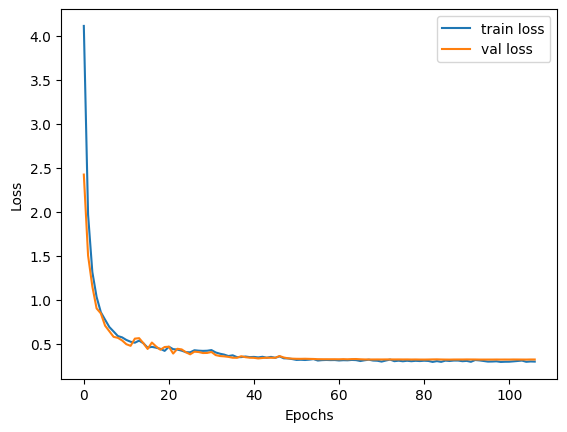

In [205]:
from keras import models, layers, callbacks, optimizers

# Define the model with improved architecture and regularization
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)), 
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.2),  
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu', kernel_regularizer='l2'), 
    layers.Dense(1,)  # Output layer
])

# Compile the model with a lower learning rate and Adam optimizer
learning_rate = 0.01
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks for early stopping and learning rate reduction
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with more epochs and callbacks
history = model.fit(X_train_scaled, y_train_top, 
                    epochs=800, 
                    validation_split=0.3, 
                    batch_size=50, 
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Plotting training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/800


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2251 - val_loss: 7.1228 - learning_rate: 0.1000
Epoch 2/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9215 - val_loss: 6.2390 - learning_rate: 0.1000
Epoch 3/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1024 - val_loss: 5.4440 - learning_rate: 0.1000
Epoch 4/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3306 - val_loss: 4.7559 - learning_rate: 0.1000
Epoch 5/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6503 - val_loss: 4.2204 - learning_rate: 0.1000
Epoch 6/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0866 - val_loss: 3.6224 - learning_rate: 0.1000
Epoch 7/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5864 - val_loss: 3.1985 - learning_rate: 0.1000
Epoch 8/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1253 - val_loss: 2.8550 - learning_rate: 0.1000
Epoch 9/800
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7919 - val_loss: 2.5090 - learning_rate: 0.1000
Epoch 10/800
35/35 ━━━━━━━━━━━━

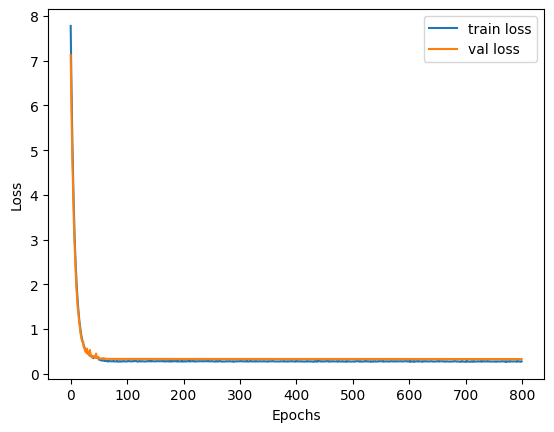

In [211]:
from keras import models, layers, callbacks, optimizers

# Define the model with improved architecture and regularization
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)), 
    layers.Dense(100, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.2),  
    layers.Dense(100, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(200, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(200, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(100, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(15, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),
    layers.Dense(6, activation='relu', kernel_regularizer='l2'), 
    layers.Dense(1,activation='linear')  # Output layer
])

# Compile the model with a lower learning rate and Adam optimizer
learning_rate = 0.1
optimizer = optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks for early stopping and learning rate reduction
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with more epochs and callbacks
history = model.fit(X_train_scaled, y_train_top, 
                    epochs=800, 
                    validation_split=0.1, 
                    batch_size=50, 
                    verbose=1,
                    callbacks=[ reduce_lr])

# Plotting training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [189]:
# from sklearn.model_selection import GridSearchCV
# !pip install scikeras
# import scikeras
# from scikeras.wrappers import KerasRegressor

# # Define a function to create your Keras model
# def create_model(learning_rate=0.001, dropout_rate=0.2, num_neurons=64, regularization_strength=0.001):
#     model = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)), 
#         layers.Dense(num_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)),
#         layers.Dropout(dropout_rate),  
#         layers.Dense(num_neurons//2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)),  
#         layers.Dropout(dropout_rate),
#         layers.Dense(num_neurons//4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)),  
#         layers.Dropout(dropout_rate),
#         layers.Dense(1)  # Output layer
#     ])
#     optimizer = optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# # Create a KerasRegressor based on your Keras model
# model = KerasRegressor(build_fn=create_model, verbose=0, dropout_rate=0.2, learning_rate=0.001, num_neurons=64, regularization_strength=0.001)

# # Define the hyperparameters grid
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'num_neurons': [64, 128, 256],
#     'regularization_strength': [0.001, 0.01, 0.1]
# }

# # Perform grid search with cross-validation
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
# grid_result = grid.fit(X_train_scaled, y_train_top)

# # Print the best parameters and corresponding score
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [172]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.338601 using {'dropout_rate': 0.2, 'learning_rate': 0.01, 'num_neurons': 128, 'regularization_strength': 0.1}


In [204]:
save_model(model, 'my_model.h5')

In [212]:

loss = model.evaluate(X_test_scaled, y_test_top)
print("Test Loss:", loss)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3787 
Test Loss: 0.36931660771369934


In [195]:
predictions = model.predict(X_test_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [196]:
predictions = np.array(predictions).reshape(-1)  # Reshape predictions to be 1-dimensional
y_test = np.array(y_test_top).reshape(-1)            # Reshape y_test to be 1-dimensional
results = pd.DataFrame({'Predictions': predictions, 'Targets': y_test})

In [197]:

results

,Predictions,Targets
0,0.804199,0.869666
1,1.385587,0.958607
2,1.157302,1.698970
3,0.844843,1.060481
4,1.208134,0.769551
...,...,...
209,1.105001,0.974694
210,1.491151,0.686133
211,0.507308,1.000000
212,1.672789,1.455932


In [198]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)

In [199]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)

In [200]:
print(r2, mse)

0.48497196077500204 0.2909224840402542


In [201]:
import structure

In [116]:
a =structure.smile_to_image("CC")
type(a)

rdkit.Chem.rdchem.Mol